# Mapmaking with limTOD: Examples

In [1]:
import numpy as np
from limTOD import (
    TODsim,
    example_scan,
    example_symm_beam_map,
    GDSM_sky_model,
    HPW_mapmaking
)
import matplotlib.pyplot as plt
import healpy as hp

In [ ]:
# Initialize the simulator with MeerKAT coordinates and example beam and sky models
# In this case, we use foreground-only sky model from GDSM
Nside = 32

from limTOD import simulator
tod_sim = TODsim(
    ant_latitude_deg=-30.7130,  # MeerKAT latitude
    ant_longitude_deg=21.4430,  # MeerKAT longitude
    ant_height_m=1054,          # MeerKAT altitude
    nside=Nside,                   # HEALPix resolution
    beam_func=simulator.example_symm_beam_map, # Return HEALPix beam array of shape (hp.nside2npix(nside))
    sky_func=GDSM_sky_model     # Return HEALPix sky map of shape (hp.nside2npix(nside))
)



**Note**: ''beam_func'' and ''sky_func'' require keyword-only arguments, two of which must be freq and nside:
```python
# beam_func(freq=, nside=xx) and sky_func(freq=xx, nside=xx)
```
Their outputs must be HEALPix maps of the sampe shape, but the shape can be one of the three types:
- 1D array of length npix for unpolarized (**I**) beam/sky 
- 2D array of shape (3, npix) for polarized (**I, Q, U**) beam/sky
- 2D array of shape (4, npix) for polarized (**I, Q, U, V**) beam/sky

In [3]:
try:
    # load simulated TODs if already exist
    data = np.load("data/simulated_TODs.npz", allow_pickle=True)
    freq_list = data["freq_list"].tolist()
    TOD_group = data["TOD_group"]
    LST_deg_list_group = data["LST_deg_list_group"]
    azimuth_deg_list_group = data["azimuth_deg_list_group"]
    elevation_deg_list_group = data["elevation_deg_list_group"]
    print("Loaded existing simulated TODs from data/simulated_TODs.npz")
except (FileNotFoundError, KeyError):
    # Generate a few example scans (2 scan modes, 5 elevations each  ==> 10 different TOD sets in total)

    n_repeats = 13  # Number of back-and-forth azimuthal scans
    time_list_setting, azimuth_list_setting = example_scan(az_s=-60.3, az_e=-42.3, dt=2.0, n_repeats=n_repeats)
    setting_start_time_utc="2019-04-23 20:41:56.397"
    setting_elevations=41.5 + (np.arange(5)-2) * 2      # In degrees
    # setting_elevations=[41.5]


    time_list_rising, azimuth_list_rising = example_scan(az_s=43.7, az_e=61.7, dt=2.0, n_repeats=n_repeats)
    rising_start_time_utc="2019-03-30 17:19:02.397"
    rising_elevations=40.5 + (np.arange(5)-2) * 2       # In degrees
    # rising_elevations=[40.5]

    freq_list = [950]  # MHz
    TOD_group = []
    LST_deg_list_group = []
    azimuth_deg_list_group = []
    elevation_deg_list_group = []
    print("Generating simulated TODs ...")

    for ele in setting_elevations:
        tod_array, _, _, LST_deg_list=tod_sim.generate_TOD(
            freq_list=freq_list,
            time_list=time_list_setting,
            azimuth_deg_list=azimuth_list_setting,
            elevation_deg=ele,
            start_time_utc=setting_start_time_utc,
            Tsys_others_TOD=None, # No extra Tsys components except sky temperature
            background_gain_TOD=None, # No background smooth gain is used here -- means that we are generating calibrated TOD
            return_LSTs=True
        )
        assert tod_array.shape == (1, len(time_list_setting))  # (n_freq, n_time)
        TOD_group.append(tod_array[0])  # Only one frequency in this example
        LST_deg_list_group.append(LST_deg_list)
        azimuth_deg_list_group.append(azimuth_list_setting)
        elevation_deg_list_group.append(ele*np.ones_like(tod_array[0])) # Constant elevation for this TOD

    for ele in rising_elevations:
        tod_array, _, _, LST_deg_list=tod_sim.generate_TOD(
            freq_list=freq_list,
            time_list=time_list_rising,
            azimuth_deg_list=azimuth_list_rising,
            elevation_deg=ele,
            start_time_utc=rising_start_time_utc,
            Tsys_others_TOD=None, # No extra Tsys components except sky temperature
            background_gain_TOD=None, # No background smooth gain is used here -- means that we are generating calibrated TOD
            return_LSTs=True
        )
        assert tod_array.shape == (1, len(time_list_rising))  # (n_freq, n_time)
        TOD_group.append(tod_array[0])  # Only one frequency in this example
        LST_deg_list_group.append(LST_deg_list)
        azimuth_deg_list_group.append(azimuth_list_rising)
        elevation_deg_list_group.append(ele*np.ones_like(tod_array[0])) # Constant elevation for this TOD

    # Save the simulated TODs and pointing information
    np.savez("data/simulated_TODs.npz",
        TOD_group=TOD_group,
        LST_deg_list_group=LST_deg_list_group,
        azimuth_deg_list_group=azimuth_deg_list_group,
        elevation_deg_list_group=elevation_deg_list_group,
        freq_list=freq_list)


Loaded existing simulated TODs from data/simulated_TODs.npz


In [33]:
beam_map = example_symm_beam_map(freq=freq_list[0], nside=tod_sim.nside)  # Beam map at the frequency of interest
lat_deg =tod_sim.ant_latitude_deg

inds = [2] # Use only two TOD sets for map-making in this example

HPW_mapmaker = HPW_mapmaking(
    beam_map=beam_map,
    LST_deg_list_group=LST_deg_list_group[inds],
    lat_deg=lat_deg,
    azimuth_deg_list_group=azimuth_deg_list_group[inds],
    elevation_deg_list_group=elevation_deg_list_group[inds],
    threshold=0.09,  # Only use pixels where beam response (divided by peak) is > threshold
    Tsys_others_operator_group=None,  # Otherwise, one can provide e.g., a list of Legendre polynomial operator of shape (n_time, n_params) here
)



Step 1: Generating the stacked abs(beam) map ... 



100%|██████████| 2860/2860 [05:30<00:00,  8.64it/s]



Step 2: Selecting pixels above threshold sensitivity ... 



100%|██████████| 2860/2860 [05:30<00:00,  8.66it/s]


In [38]:
sky_vec = GDSM_sky_model(freq=freq_list[0], nside=tod_sim.nside)[HPW_mapmaker.pixel_indices]  # Sky map at the frequency of interest

cov_inv = np.zeros(HPW_mapmaker.num_pixels) / (50.0**2)  # Assume white noise with RMS = 20.0 K for simplicity

In [39]:
cutoff_freq_group = [0.001] * len(TOD_group)  # Cutoff frequency for high-pass filtering in Hz (default: 0.001 Hz), one for each TOD set

sky_map_est, sky_map_uncertainty = HPW_mapmaker(
    TOD_group=np.array(TOD_group[inds]), 
    dtime=2.0, 
    cutoff_freq_group=np.array(cutoff_freq_group)[inds],
    gain_group=None, # As default, no gain calibration is to be performed
    known_injection_group=None, # As default, no known injection signal is considered here
    Tsky_prior_mean=sky_vec,  # Use the GDSM sky model as prior mean
    Tsky_prior_inv_cov_diag=cov_inv,  
    Tsys_other_prior_mean_group=None, # As default, no prior on other Tsys components
    Tsys_other_prior_inv_cov_group=None, # As default, no prior on other Tsys components
    regularization=0.0,
    return_full_cov=False,
)

Estimated noise variance: 0.236038
Linear algebra error: Matrix is singular.
Falling back to pseudo-inverse solution...


/Users/zzhang/Workspace/limTOD/limTOD/visual.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


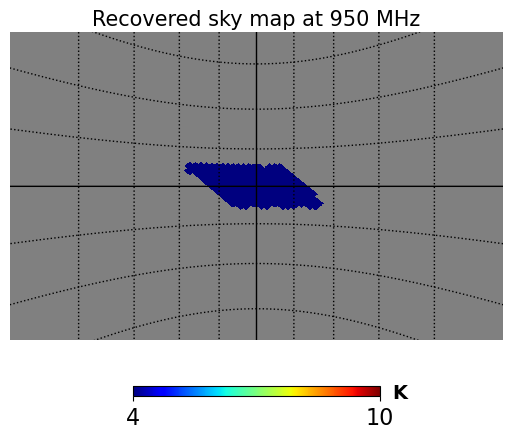

In [40]:
from limTOD.visual import gnomview_patch, view_patch_map

gnomview_patch(map=sky_map_est, 
                nside=Nside,
                pixel_indices=HPW_mapmaker.pixel_indices,
                sky_min=4,
                sky_max=10,
                res=5,
                xsize=1600,
                ysize=1000,
                title="Recovered sky map at {} MHz".format(freq_list[0])
            )

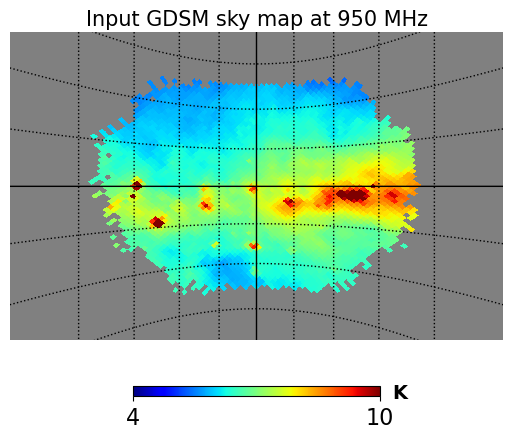

In [12]:
gnomview_patch(map=sky_vec, 
                nside=Nside,
                sky_min=4,
                sky_max=10,
                res=5,
                xsize=1600,
                ysize=1000,
                pixel_indices=HPW_mapmaker.pixel_indices, 
                title="Input GDSM sky map at {} MHz".format(freq_list[0])
            )